In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier,plot_tree


## 1. Data reader

In [3]:
train = pd.read_csv('./data/cs-training.csv',index_col=0)
test = pd.read_csv('./data/cs-test.csv',index_col=0)
sample = pd.read_csv('./data/sampleEntry.csv',index_col=0)
features = train.columns[1:]
label = 'SeriousDlqin2yrs'

In [4]:
## Merge train and test data to further data process
train['train_or_test'] = 1
test['train_or_test'] = 0
all_data = pd.concat([train,test])
all_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,train_or_test
1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1
3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,1
4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,1
5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1


In [5]:
## fill NA values ,use forward filling
all_data.fillna(method='ffill',inplace=True)
all_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,train_or_test
1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1
3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,1
4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,1
5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1


In [6]:
## Make sure there is no NA value in all_data
np.sum(all_data.isna())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
train_or_test                           0
dtype: int64

## 2. Drop outlier and make normalization

In [7]:
for col in features:
    all_data.loc[:,col] = winsorize(all_data.loc[:,col],limits=[0.005,0.005])
all_data.loc[:,features] = (all_data.loc[:,features] - all_data.loc[:,features].mean()) / all_data.loc[:,features].std()

In [8]:
all_data.loc[:,'DebtRatio'] = winsorize(all_data.loc[:,'DebtRatio'],limits=[0.005,0.001])

In [9]:
all_data['DebtRatio'].describe()

count    2.515030e+05
mean    -2.440961e-17
std      1.000000e+00
min     -3.395364e-01
25%     -3.393539e-01
50%     -3.391537e-01
75%     -3.386344e-01
max      6.169604e+00
Name: DebtRatio, dtype: float64

## 3. Feature Analysis

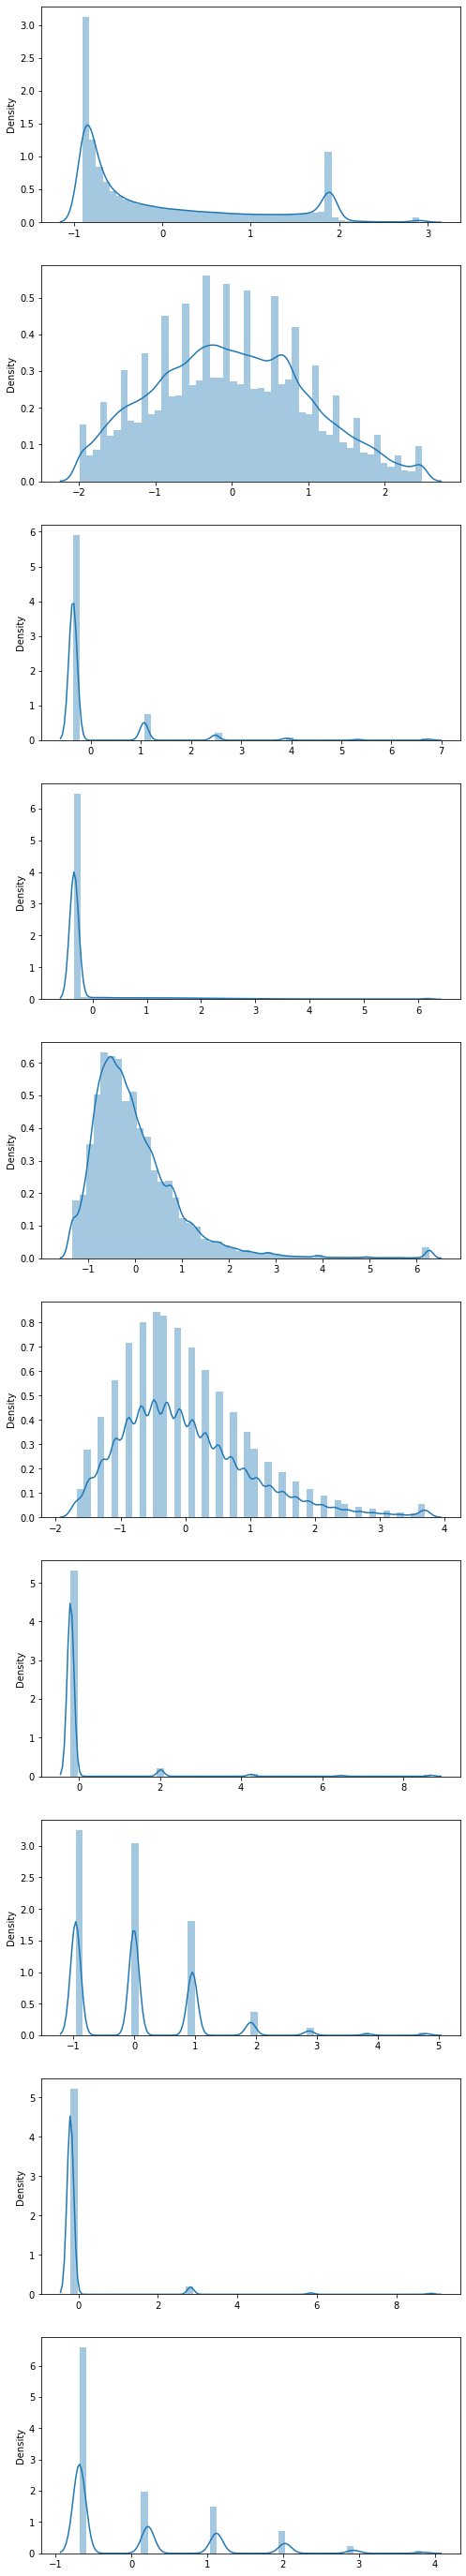

In [10]:
n = len(features)
fig = plt.figure(figsize=(8,5*n))
for i,col in enumerate(features):
    fig.add_subplot(n,1,i+1)
    sns.distplot(all_data[col].values)

## 4. Select features

In [11]:
new_train = all_data.loc[all_data['train_or_test']==1]
train_x = new_train[features]
train_y = new_train[label]
lr = LogisticRegression(penalty='l1',solver='liblinear',C=0.00010195)
lr.fit(train_x,train_y)
lr.coef_

array([[0.00025047, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.13074532, 0.        , 0.        , 0.        ]])

In [12]:
best_features = [list(features)[0],list(features)[6]]
best_features

['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate']

## 5. Logistic Regression

In [13]:
new_train = all_data.loc[all_data['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for coef in [0.00015,0.0002,0.001,0.01,0.1]:
        lr = LogisticRegression(penalty='l1',solver='liblinear',C=coef)
        lr.fit(train_x, train_y)
        valid_pred = lr.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with C = {coef}, vaild AUC is :{round(score,3)}')

fold1: with C = 0.00015, vaild AUC is :0.814
fold1: with C = 0.0002, vaild AUC is :0.813
fold1: with C = 0.001, vaild AUC is :0.81
fold1: with C = 0.01, vaild AUC is :0.809
fold1: with C = 0.1, vaild AUC is :0.809
fold2: with C = 0.00015, vaild AUC is :0.81
fold2: with C = 0.0002, vaild AUC is :0.81
fold2: with C = 0.001, vaild AUC is :0.806
fold2: with C = 0.01, vaild AUC is :0.804
fold2: with C = 0.1, vaild AUC is :0.804
fold3: with C = 0.00015, vaild AUC is :0.811
fold3: with C = 0.0002, vaild AUC is :0.81
fold3: with C = 0.001, vaild AUC is :0.807
fold3: with C = 0.01, vaild AUC is :0.806
fold3: with C = 0.1, vaild AUC is :0.806
fold4: with C = 0.00015, vaild AUC is :0.82
fold4: with C = 0.0002, vaild AUC is :0.82
fold4: with C = 0.001, vaild AUC is :0.818
fold4: with C = 0.01, vaild AUC is :0.817
fold4: with C = 0.1, vaild AUC is :0.817
fold5: with C = 0.00015, vaild AUC is :0.822
fold5: with C = 0.0002, vaild AUC is :0.821
fold5: with C = 0.001, vaild AUC is :0.818
fold5: with C 

In [18]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

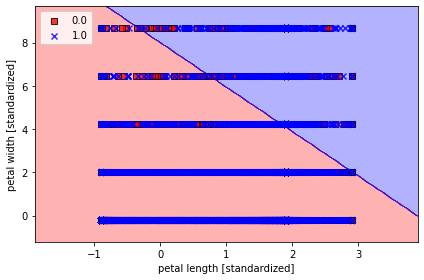

In [19]:
plot_decision_regions(X=train_x, 
                      y=train_y,
                      classifier=lr)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 6. SVM

In [22]:
new_train = all_data.loc[all_data['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for coef in [0.00015,0.0002,0.001,0.01,0.1]:
        sv = svm.SVC(max_iter=1000, kernel = 'linear',probability=True,C=coef)
        sv.fit(train_x, train_y)
        valid_pred = sv.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with C = {coef}, vaild AUC is :{round(score,3)}')

fold1: with C = 0.00015, vaild AUC is :0.775
fold1: with C = 0.0002, vaild AUC is :0.778
fold1: with C = 0.001, vaild AUC is :0.775
fold1: with C = 0.01, vaild AUC is :0.778
fold1: with C = 0.1, vaild AUC is :0.776
fold2: with C = 0.00015, vaild AUC is :0.229
fold2: with C = 0.0002, vaild AUC is :0.232
fold2: with C = 0.001, vaild AUC is :0.229
fold2: with C = 0.01, vaild AUC is :0.231
fold2: with C = 0.1, vaild AUC is :0.769
fold3: with C = 0.00015, vaild AUC is :0.775
fold3: with C = 0.0002, vaild AUC is :0.226
fold3: with C = 0.001, vaild AUC is :0.773
fold3: with C = 0.01, vaild AUC is :0.775
fold3: with C = 0.1, vaild AUC is :0.225
fold4: with C = 0.00015, vaild AUC is :0.215
fold4: with C = 0.0002, vaild AUC is :0.218
fold4: with C = 0.001, vaild AUC is :0.214
fold4: with C = 0.01, vaild AUC is :0.218
fold4: with C = 0.1, vaild AUC is :0.216
fold5: with C = 0.00015, vaild AUC is :0.215
fold5: with C = 0.0002, vaild AUC is :0.217
fold5: with C = 0.001, vaild AUC is :0.214
fold5: w

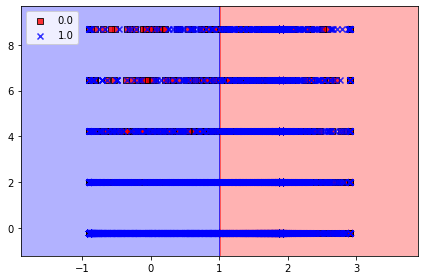

In [23]:
plot_decision_regions(X=train_x, 
                      y=train_y,
                      classifier=sv)

# plt.xlabel('petal length [standardized]')
# plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 7. Decision Tree

In [17]:
new_train = all_data.loc[all_data['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for md in [3,4,5,6]:
        dc = DecisionTreeClassifier(max_depth=md)
        dc.fit(train_x, train_y)
        valid_pred = dc.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with max_depth = {coef}, vaild AUC is :{round(score,3)}')

fold1: with max_depth = 0.1, vaild AUC is :0.805
fold1: with max_depth = 0.1, vaild AUC is :0.814
fold1: with max_depth = 0.1, vaild AUC is :0.817
fold1: with max_depth = 0.1, vaild AUC is :0.817
fold2: with max_depth = 0.1, vaild AUC is :0.802
fold2: with max_depth = 0.1, vaild AUC is :0.812
fold2: with max_depth = 0.1, vaild AUC is :0.814
fold2: with max_depth = 0.1, vaild AUC is :0.811
fold3: with max_depth = 0.1, vaild AUC is :0.802
fold3: with max_depth = 0.1, vaild AUC is :0.812
fold3: with max_depth = 0.1, vaild AUC is :0.816
fold3: with max_depth = 0.1, vaild AUC is :0.817
fold4: with max_depth = 0.1, vaild AUC is :0.808
fold4: with max_depth = 0.1, vaild AUC is :0.819
fold4: with max_depth = 0.1, vaild AUC is :0.823
fold4: with max_depth = 0.1, vaild AUC is :0.824
fold5: with max_depth = 0.1, vaild AUC is :0.807
fold5: with max_depth = 0.1, vaild AUC is :0.819
fold5: with max_depth = 0.1, vaild AUC is :0.82
fold5: with max_depth = 0.1, vaild AUC is :0.821


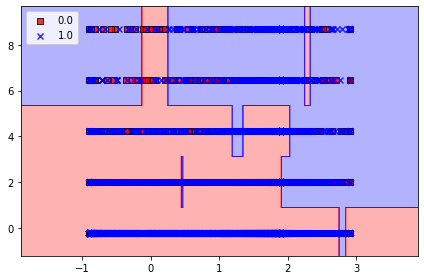

In [21]:
plot_decision_regions(X=train_x, 
                      y=train_y,
                      classifier=dc)

# plt.xlabel('petal length [standardized]')
# plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()